# Recognize Phones from Speech Sentences using Hidden Markov Model
## Preliminary Testing on a SINGLE vowel

For this project, a hidden markov model (HMM) is applied to create phone models for three different vowels (/a/, /u/, /i/). Then all three phone models are used to infer the state of a given speech sentence. The objective is to recognize the three phones from any given sentence with their corresponding time indices.

In [1]:
#%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import scipy.io as sio
import numpy as np

from scipy.signal import hilbert, chirp
from hmmlearn_YG import hmm
from python_speech_features import mfcc
from vad import VAD

### Hidden Markov Models

[HMMs](https://en.wikipedia.org/wiki/Hidden_Markov_model) are a class of probabilistic graphical models that can predict the sequence of states, given a sequence of observations that are dependent on those states, and when the states themselves are unobservable. HMMs have seen widespread success in a variety of applications, from Speech processing and Robotics to DNA Sequencing. An HMM operates according to a set of assumptions, which are :  
1. **Markov Assumption**  
Current state is dependent on only the previous state.  
2. **Stationarity Assumption**  
Transition probabilities are independent of time of transition.  
3. **Independence Assumption**  
Each observation depends solely on the current underlying state (which in turn depends on the previous one), and is independent of other observations.  

An HMM is a **Generative model**, in that it attempts to find the probability of a set of observations being produced or *generated* by a class.  The parameters that we pass to the HMM class, defined below, are:  
$O$ = a set of observations  
$S$ = a set of states  
$A$ = transition probabilities, represented as a matrix  
$B$ = emission probabilities, represented as a matrix  
$\pi$ = initial state probabilties  
$Y$ = sequence observed  

## 1. Load Vowel Data for Training the HMM
Load one normal vowels (/a/ normal, /u/ normal, /i/ normal) but only using voice channels, the normal vowels are used for fitting the Hidden Markov Model, generate all hidden state distributions.

In [2]:
# Select Subject and Vowel
subject = "R031"
vowel = "u_normal"

In [3]:
# Extract variables that contain related data
vowel_data = sio.loadmat('Data/%s/%s.mat' % (subject, vowel))

## 3. Extract Features from Vowels
Load the vowels and extrac MFCC features from each repetition to construct the training vectors to train the HMM model
### Mel Frequency Cepstral Coefficient (MFCC) 
1. Frame the signal into short frames.
2. For each frame calculate the periodogram estimate of the power spectrum.
3. Apply the mel filterbank to the power spectra, sum the energy in each filter.
4. Take the logarithm of all filterbank energies.
5. Take the DCT of the log filterbank energies.
6. Keep DCT coefficients 2-13, discard the rest.

Example:
<img src="Figure/time_signal.jpg" width="700"/>
<img src="Figure/mfcc_raw.jpg" width="700"/>

### Reference
Davis, S. Mermelstein, P. (1980) Comparison of Parametric Representations for Monosyllabic Word Recognition in Continuously Spoken Sentences. In IEEE Transactions on Acoustics, Speech, and Signal Processing, Vol. 28 No. 4, pp. 357-366

X. Huang, A. Acero, and H. Hon. Spoken Language Processing: A guide to theory, algorithm, and system development. Prentice Hall, 2001.

In [4]:
win_overlap = 25
win_step    = 10

Total Repetitions: 55
Sampling Rate:  20000


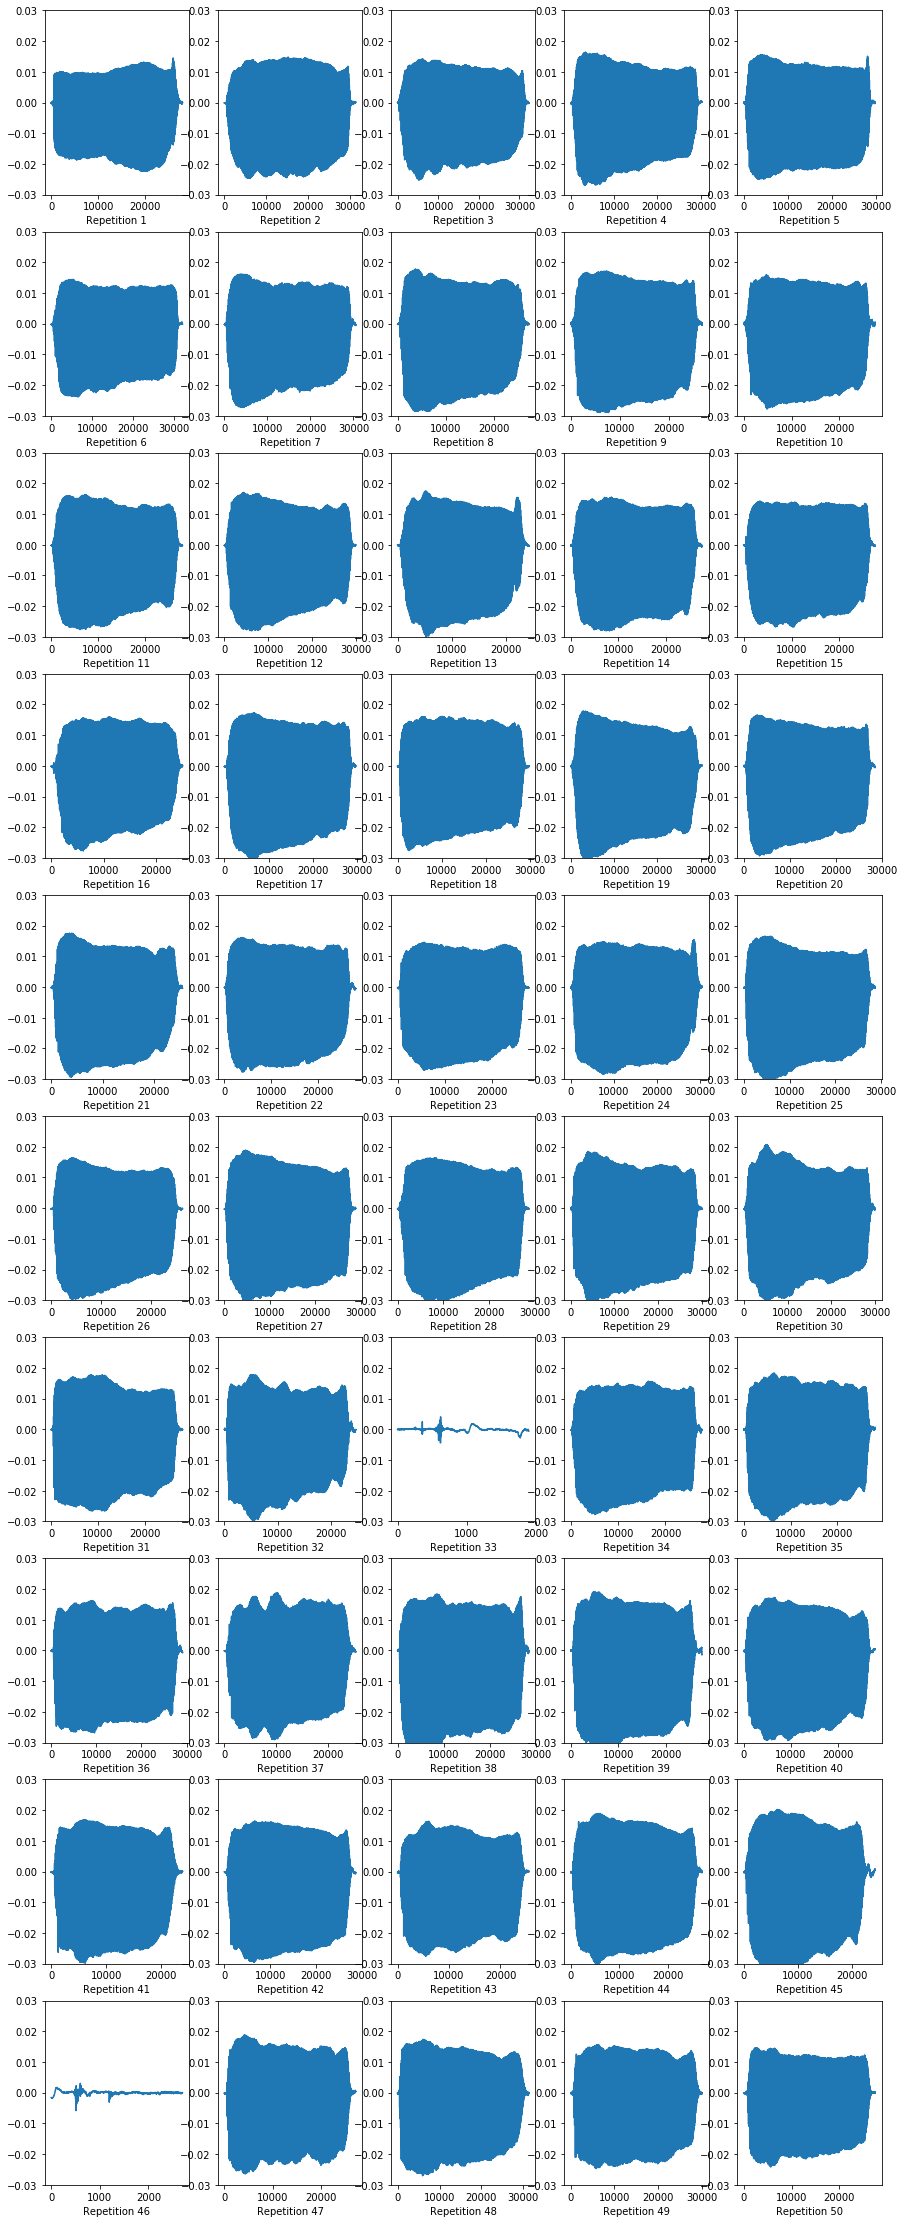

In [25]:
Tmp_Data = vowel_data['data']
Start = vowel_data['datastart']
End = vowel_data['dataend']
Sample_Rate = vowel_data['samplerate']

rep = Start.shape[1]
sample_rate = int(Sample_Rate[4,0])

print('Total Repetitions:', rep)
print("Sampling Rate: ", sample_rate)

# Extract features from all 55 rep of voice signals
vowel_feature = np.empty((0, 13))
length = []

plt.figure(figsize=(15, 40))
for i in range(50):
    # ----- Extract the 2 channels voice signal -----
    voice_sample_channel = np.zeros((2*sample_rate, 2))
    
    # For the left channel
    # Get the indices for the current repetiton
    voice_start = int(Start[4,i]) - 1
    voice_end = int(End[4,i])
    # Extract and center the current voice signal
    voice_sample_tmp = Tmp_Data[0,voice_start:voice_end]
    voice_sample_channel[:,0] = voice_sample_tmp - np.mean(voice_sample_tmp)

    # For the right channel
    # Get the indices for the current repetiton
    voice_start = int(Start[5,i]) - 1
    voice_end = int(End[5,i])
    # Extract and center the current voice signal
    voice_sample_tmp = Tmp_Data[0,voice_start:voice_end]
    voice_sample_channel[:,1] = voice_sample_tmp - np.mean(voice_sample_tmp)

    # Combine from sterero into mono
    voice_sample = np.mean(voice_sample_channel, axis=1, 
                           dtype=voice_sample_channel.dtype)
    
    # ----- Detect voice activation -----
    vad=VAD(voice_sample, sample_rate, nFFT=512, win_length=0.025, hop_length=0.01, theshold=0.99)
    # peform the differentiation
    # print(vad.reshape(-1))
    voice_detect = list(np.diff(vad.reshape(-1)))
    # print(voice_detect)
    i_start = int(voice_detect.index(1)*0.01*sample_rate)
    i_end   = int((voice_detect.index(-1)*0.01+0.075)*sample_rate)
    # print(i_start, i_end)

    plt.subplot(10, 5, i+1)
    plt.plot(voice_sample[range(i_start, i_end+1)])
    plt.ylim((-0.03, 0.03))
    plt.xlabel("Repetition %d" % (i+1))

plt.show()

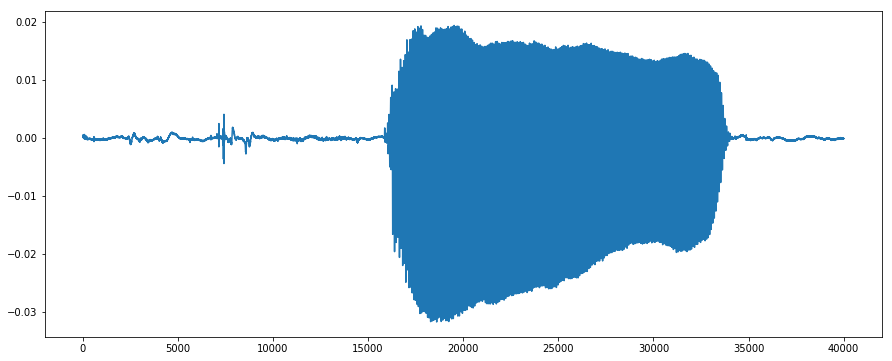

In [15]:
# Quick examine for individual signals
i = 32
# ----- Extract the 2 channels voice signal -----
voice_sample_channel = np.zeros((2*sample_rate, 2))

# For the left channel
# Get the indices for the current repetiton
voice_start = int(Start[4,i]) - 1
voice_end = int(End[4,i])
# Extract and center the current voice signal
voice_sample_tmp = Tmp_Data[0,voice_start:voice_end]
voice_sample_channel[:,0] = voice_sample_tmp - np.mean(voice_sample_tmp)

# For the right channel
# Get the indices for the current repetiton
voice_start = int(Start[5,i]) - 1
voice_end = int(End[5,i])
# Extract and center the current voice signal
voice_sample_tmp = Tmp_Data[0,voice_start:voice_end]
voice_sample_channel[:,1] = voice_sample_tmp - np.mean(voice_sample_tmp)

# Combine from sterero into mono
voice_sample = np.mean(voice_sample_channel, axis=1, 
                       dtype=voice_sample_channel.dtype)

plt.figure(figsize=(15, 6))
plt.plot(voice_sample)
plt.show()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0

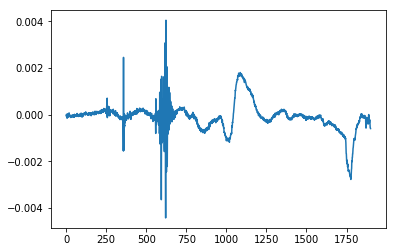

In [18]:
vad=VAD(voice_sample, sample_rate, nFFT=512, win_length=0.025, hop_length=0.01, theshold=0.99)
# peform the differentiation
print(vad.reshape(-1))
voice_detect = list(np.diff(vad.reshape(-1)))
print(voice_detect)
i_start = int(voice_detect.index(1)*0.01*sample_rate)
i_end   = int((voice_detect.index(-1)*0.01+0.075)*sample_rate)
print(i_start, i_end)

# plt.figure(figsize=(15, 6))
plt.plot(voice_sample[range(i_start, i_end+1)])
plt.show()

In [ ]:
# MFCC feature vectors are typically computed every 10ms using 
# an overlapping analysis window of 25ms
mfcc_feat = mfcc(voice_sample, sample_rate, 0.001*win_overlap, 0.001*win_step)

# Concatnate individual feature into one single array
vowel_feature = np.append(vowel_feature, mfcc_feat, axis=0)
length.append(int(mfcc_feat.shape[0]))

print('Dimensionality of ONE vowel features: ', vowel_feature[0].shape)        
print('Total # of feature sequence: ', vowel_feature.shape[0])

#### Function: Load training vowels and extract features
Load 50 repetitions from normal vowels production and then extract MFCC cofficients from each vowel to train the HMM model

In [ ]:
def load_vowels_training(vowel):
    Tmp_Data = vowel['data']
    Start = vowel['datastart']
    End = vowel['dataend']
    Sample_Rate = vowel['samplerate']

    rep = Start.shape[1]
    sample_rate = Sample_Rate[4,0]

    print('Total Repetitions:', rep)
    print("Sampling Rate: ", sample_rate)

    # Extract features from all 55 rep of voice signals
    vowel_feature = np.empty((0, 13))
    length = []
    for i in range(50):
        # Get the indices for the current repetiton
        voice_start = int(Start[4,i]) - 1
        voice_end = int(End[4,i])

        # Extract and center the current voice signal
        voice_sample = Tmp_Data[0,voice_start:voice_end]
        voice_sample = voice_sample - np.mean(voice_sample)

        # MFCC feature vectors are typically computed every 10ms using 
        # an overlapping analysis window of 25ms
        mfcc_feat = mfcc(voice_sample, sample_rate, 0.001*win_overlap, 0.001*win_step)

        # Concatnate individual feature into one single array
        vowel_feature = np.append(vowel_feature, mfcc_feat, axis=0)
        length.append(int(mfcc_feat.shape[0]))

    print('Dimensionality of ONE vowel features: ', vowel_feature[0].shape)        
    print('Total # of feature sequence: ', vowel_feature.shape[0])

    return vowel_feature, length

In [ ]:
feature_a_tr, length_a_tr = load_vowels_training(vowel_data)

## 4. Training a HMM Model
Use Gaussian distribution for estimating emission probabilities

In [ ]:
num_components = 3

In [ ]:
# Initialize HMM model and estimate parameters for /a/ normal
transmat = np.zeros((num_components, num_components))

# Left-to-right: each state is connected to itself and its
# direct successor.
for i in range(num_components):
    if i == num_components - 1:
        transmat[i, i] = 1.0
    else:
        transmat[i, i] = transmat[i, i + 1] = 0.5

        
print(transmat)

# Always start in first state
startprob = np.zeros(num_components)
startprob[0] = 1.0

model_vowel = hmm.GaussianHMM(n_components=num_components,  
                              covariance_type="full",
                              params="mct", 
                              init_params="cm",
                              n_iter=100)

model_vowel.startprob = startprob.copy()
model_vowel.transmat_ = transmat.copy()

model_vowel.fit(feature_a_tr, length_a_tr)
model_vowel.monitor_

print(model_vowel.transmat_)
print(model_vowel.means_.shape)
print(model_vowel.covars_.shape)

In [ ]:
print(model_vowel.means_)
print(model_vowel.covars_)

### To-Do: 
Re-order the state sequence based on the variance of that particular state. The intuition here is assuming that the empty (quiet) state 0 has the smallest variance; the beginning state 1 of a vowel has the medium amount of variance; and the main vowel state 2 should have the largest variance.
### !!!!!Note to myself!!!!!
Inside GaussianHMM class, \_init function, there is a step uses kmean to cluster given observations for the initial estimation of means

## 5. Use Trainned HMM Model to Perform State Prediction on Given Voices
Use the three HMM models which are estimated previously for /a/ normal, /u/ normal, /i/ normal to:
1. Find corresponding states on original vowel signals for reference.
2. Predict corresponding states for given syllables to validate the models.
3. Predict corresponding states for given sentences to test the models.

### 5.1 Use vowels as tesing voice signal

#### Function: Load testing voice (vowels or speeches), extract features
Similar to the function of loading training vowels. However, this only loads one repetition for qualitative analysis.

In [ ]:
def load_voice_testing(voice, index, L):
    Tmp_Data = voice['data']
    Start = voice['datastart']
    End = voice['dataend']
    Sample_Rate = voice['samplerate']

    rep = Start.shape[1]
    sample_rate = Sample_Rate[4,0]

    # Extract features from all 55 rep of voice signals
    voice_feature = np.empty((0, 13))
    length = []

    # Get the indices for the current repetiton
    voice_start = int(Start[4,index]) - 1
    voice_end = int(End[4,index])

    # Extract and center the current voice signal
    voice_sample = Tmp_Data[0,voice_start:voice_end]
    voice_sample = voice_sample - np.mean(voice_sample)

    # MFCC feature vectors are typically computed every 10ms using 
    # an overlapping analysis window of 25ms
    mfcc_feat = mfcc(voice_sample, sample_rate, 0.001*win_overlap, 0.001*win_step)

    # Concatnate individual feature into one single array
    voice_feature = np.append(voice_feature, mfcc_feat, axis=0)
    length.append(int(mfcc_feat.shape[0]))

    # Plot ONE voice sample signals    
    plt.figure(1, figsize=(15, 6))
    plt.plot(voice_sample)
#     plt.ylim(-0.04, 0.04)
    plt.xlim(L[0], L[1])
    plt.title("Testing Voice")
    plt.show()
    
    return voice_sample, voice_feature, length

#### load testing vowels

In [ ]:
voice_te, feature_te, length_te = load_voice_testing(vowel_data, 54, [0, 40000])

#### Function: Restore states prediction from the feature space to the original signal space
The voice feature vectors are extracted every 10ms using a 25ms overlapping window. Thus, each predicted state for the feature vector need to be expanded to the original voice signal in order to get the indices for the start and end for the states.

In [ ]:
color_vec = ['r','g','y','c','m']

In [ ]:
def predict_voice_state(model, voice_sample, voice_feature, c, L):
    """ THIS PARAMETER NEED TO BE FURTHER INVESTIGATED """
    # sample window = time x sampling rate
    sample_window = int(0.01 * 20000)
    """ THIS PARAMETER NEED TO BE FURTHER INVESTIGATED """

    # Use trainned HMM to predict the states
    state_prediction = model.predict(voice_feature)
    state_length = len(state_prediction)

#     print(state_prediction)

    # Expand the state prediction from feature vectors to the original
    # voice signals
    # i - index
    # s - state
    voice_state = np.zeros((num_components,voice_sample.size))
    for i,s in enumerate(state_prediction):

        # Skip the first and last state to make it able to detect 
        # after differentiation
        # the first state
        if i == 0:
            for j in range(1, sample_window):
                voice_state[s,j] = 1
        # from the second state until the second last state
        elif i < state_length - 1:
            for j in range(i*sample_window, i*sample_window+sample_window):
                voice_state[s,j] = 1
        # last state
        else:
            for j in range(i*sample_window, voice_sample.size-1):
                voice_state[s,j] = 1

    # Plot the expanded voice state sequence
    plt.figure(2, figsize=(15, 6))
    plt.plot(voice_sample, c='b', alpha=0.8)
#     c = ['r','g','y']

    for s in range(0,num_components):
        i_start = []    # all start indices for the current state
        i_end   = []    # all end indices for the current state

        # peform the differentiation
        voice_detect = np.diff(voice_state[s,:])
        # find non-zero elements +1/-1
        for i, v in enumerate(voice_detect):
            if v == 1:
                i_start.append(i)
            elif v == -1:
                i_end.append(i)

        for i,j in zip(i_start, i_end):
            p = plt.axvspan(i, j, facecolor=c[s] , alpha=0.4)

    plt.xlim(L[0], L[1])    
    plt.show()

#### Predict testing vowels
State sequence order: red   ---> 0, green ---> 1, yello ---> 2

In [ ]:
predict_voice_state(model_vowel, voice_te, feature_te, color_vec, [0, 40000])

### 5.2 Using syllable1 as tesing voice signal

“afa afa afa ifi ifi ifi ufu ufu ufu”

In [ ]:
syllable = sio.loadmat('Data/%s/syllable1.mat' % subject)

In [ ]:
voice_syl_te, feature_syl_te, length_syl_te = load_voice_testing(syllable, 0, [0,120000])
predict_voice_state(model_vowel, voice_syl_te, feature_syl_te, color_vec, [0,120000])

zoom in the first part of this syllable sequence to better evaluate "afa afa afa"

In [ ]:
voice_syl_te, feature_syl_te, length_syl_te = load_voice_testing(syllable, 0, [0,30000])
predict_voice_state(model_vowel, voice_syl_te, feature_syl_te, color_vec, [0,30000])

### 5.3 Using sentence as tesing voice signal
<img src="Figure/sentence_ref.png" width="500"/>

### Reference
Y.-A. Lien, C. Gattuccio, and C. Stepp, “Effects of phonetic context on relative fundamental frequency,” Journal of Speech, Language, and Hearing Research, vol. 57, pp. 1259–1267, 2014.

Elizabeth S.Heller Murray, Gabrielle L. Hands, Carolyn R. Calabrese, Cara E. Stepp, Effects of Adventitious Acute Vocal Trauma: Relative Fundamental Frequency and Listener Perception, Journal of Voice, Volume 30, Issue 2, 2016, Pages 177-185.

##### Sentence 1 
“The d**ew shi**mmered over m**y shi**ny blue shell again”

In [ ]:
sentence1 = sio.loadmat('Data/%s/sentence1.mat' % subject)
voice_stn_te, feature_stn_te, length_stn_te = load_voice_testing(sentence1, 0, [0, 60000])
predict_voice_state(model_vowel, voice_stn_te, feature_stn_te, color_vec,[0, 60000])

##### Sentence 2
“Only w**e fee**l you d**o fai**l in n**ew fa**llen dew”

In [ ]:
sentence2 = sio.loadmat('Data/%s/sentence2.mat' % subject)
voice_stn_te, feature_stn_te, length_stn_te = load_voice_testing(sentence2, 0, [0, 60000])
predict_voice_state(model_vowel, voice_stn_te, feature_stn_te, color_vec,[0, 60000])